In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import glob
import os
import scipy
%matplotlib inline

In [7]:
a = np.load("data_toy/milan_processed_train.npz")['x']
c = np.load("data_toy/milan_processed_train.npz")['y']

In [16]:
a.shape
b = np.max(a[...])
c = 2 * c / b - 1
np.min(c[...])

-1.0066100357063839

In [11]:
c.shape

(564, 100, 100, 10)

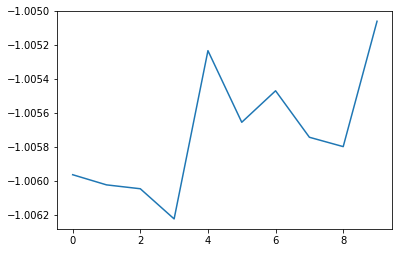

In [15]:
plt.plot(c[50,50,50,:])

In [26]:
np.max(a[...])

1.0

## Preprocess The Data

In [ ]:
#read dataset
path = 'data'   # specify path where we keep the data
all_files = glob.glob(os.path.join(path, "*.txt")) 
df_from_each_file = (pd.read_csv(f,sep='\t',header=None,usecols=[0,1,2,6],
                                 names=['Square id','TimeInterval','Country Code','Traffic']) \
                     for f in all_files)
df = pd.concat(df_from_each_file, ignore_index=True)

#convert unix timecode to dates
df['Time interval'] = pd.to_datetime(df['TimeInterval'],unit='ms')
#drop NaN values
df.dropna(inplace=True)
#Sum rows that are on the same square and time
#ie marginalize over Country Code
df = df.groupby(['Square id','TimeInterval'],as_index=False)['Traffic'].sum()
#df.head(10)

In [ ]:
df['x'] = (df['Square id']-1) % 100 
df['y'] = (df['Square id']-1) // 100
df['t'] = (df['TimeInterval']) // 600000 - 2305434
df.drop('Square id',inplace=True,axis=1)
df.drop('TimeInterval',inplace=True,axis=1)

In [ ]:
df = df[['x','y','t','Traffic']]

In [ ]:
df.head(10)

## Convert to 3D NP array

In [ ]:
#transform data to 3D numpy array (x,y,t)
#ref: https://stackoverflow.com/questions/47715300/convert-a-pandas-dataframe-to-a-multidimensional-ndarray
grouped = df.groupby(['x','y','t']).mean()
shape = tuple(map(len,grouped.index.levels))
raw= np.zeros(shape)
raw[grouped.index.labels] = grouped.values.flat
raw.shape

In [ ]:
np.max(raw[:,:,:])

In [7]:
raw[0,0,2]

0.05460092975437236

## Generate Training Examples (x, y) for Supervised Learning

In [8]:
S = 12          # number of observations
K = 4           # number of predictions
L = raw.shape[2]

We transform our data into a supervised machine learning problem. The x variable contains observations and y the target values.
They are a 4D tensor with the following dimensions
* 1st dimension is example number N
* 2nd dimension is spatial coordinate x
* 3rd dimension is spatial coordinate y
* 4th dimension if temporal coordinate t

In [9]:
# create a batch as a 4D tensor
x_t = [raw[:,:,t:t+S] for t in range(L-S-K)]
y_t = [raw[:,:,t+S:t+S+K] for t in range(L-S-K)]

x = np.array(x_t)
y = np.array(y_t)

In [10]:
x.shape

(272, 100, 100, 12)

In [11]:
y.shape

(272, 100, 100, 4)

## Visualisations

### Plotting one time step

In [13]:
norm = Normalize(vmin=0,vmax=100)

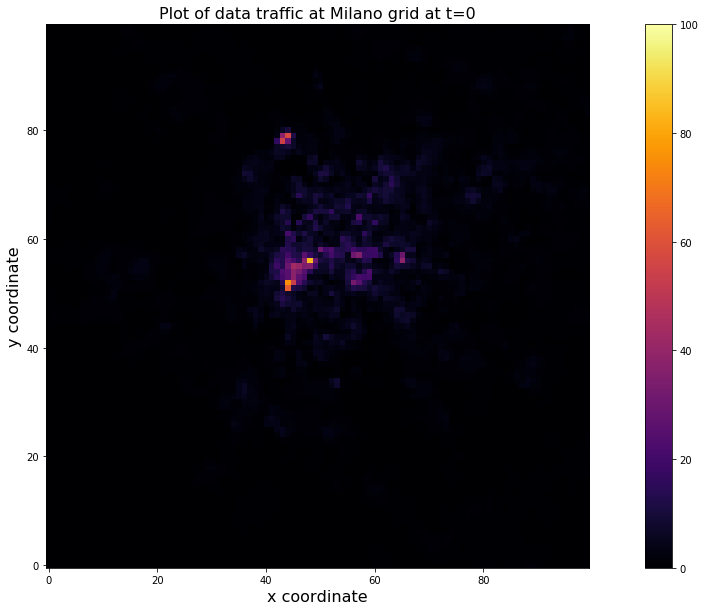

In [23]:
plt.figure(figsize=(20,10))
plt.imshow(raw[...,0],origin='lower',norm=norm,cmap='inferno')
plt.title('Plot of data traffic on Milano grid at t=0',fontsize=16)
plt.xlabel('x coordinate',fontsize=16)
plt.ylabel('y coordinate',fontsize=16)
plt.colorbar()

### Plotting the mean at each cell over all time steps

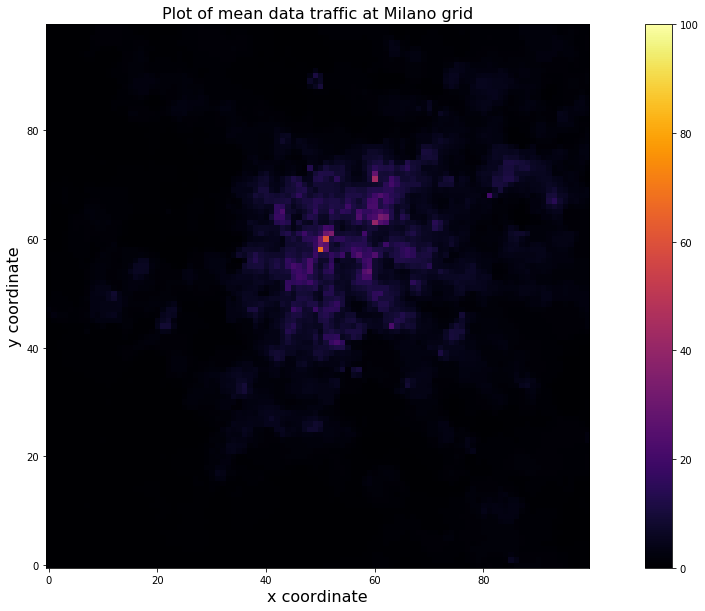

In [24]:
means = np.mean(raw,axis=2)
plt.figure(figsize=(20,10))
plt.imshow(means,origin='lower',norm=norm,cmap='inferno')
plt.title('Plot of mean data traffic on Milano grid',fontsize=16)
plt.xlabel('x coordinate',fontsize=16)
plt.ylabel('y coordinate',fontsize=16)
plt.colorbar()

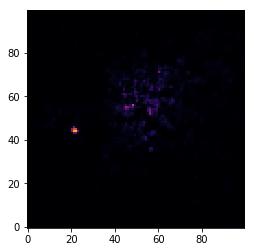

In [34]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure()
frames = raw.shape[2]
ims = []
for i in range(frames):
    im = plt.imshow(raw[...,i], animated=True,origin='lower',norm=norm,cmap='inferno')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

ani.save('dynamic_images.mp4')


In [35]:
HTML(ani.to_html5_video())

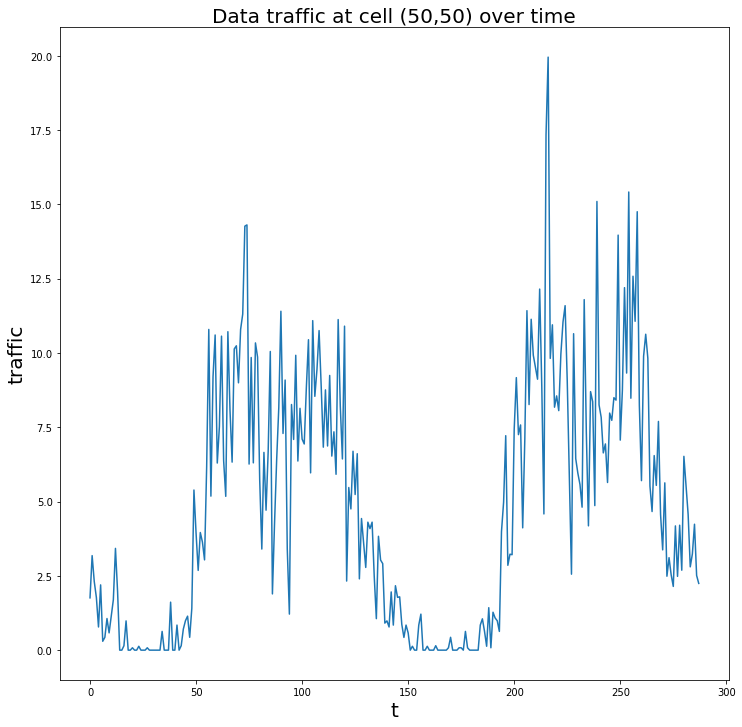

In [99]:
plt.figure(figsize=(12,12))
t = np.arange(frames)
y = raw[50,50,:]
tnew = np.linspace(0,frames,num=1000)
plt.plot(t,y,'-')
plt.title('Data traffic at cell (50,50) over time',fontsize=20)
plt.ylabel('traffic',fontsize=20)
plt.xlabel('t',fontsize=20)

<function matplotlib.pyplot.show>

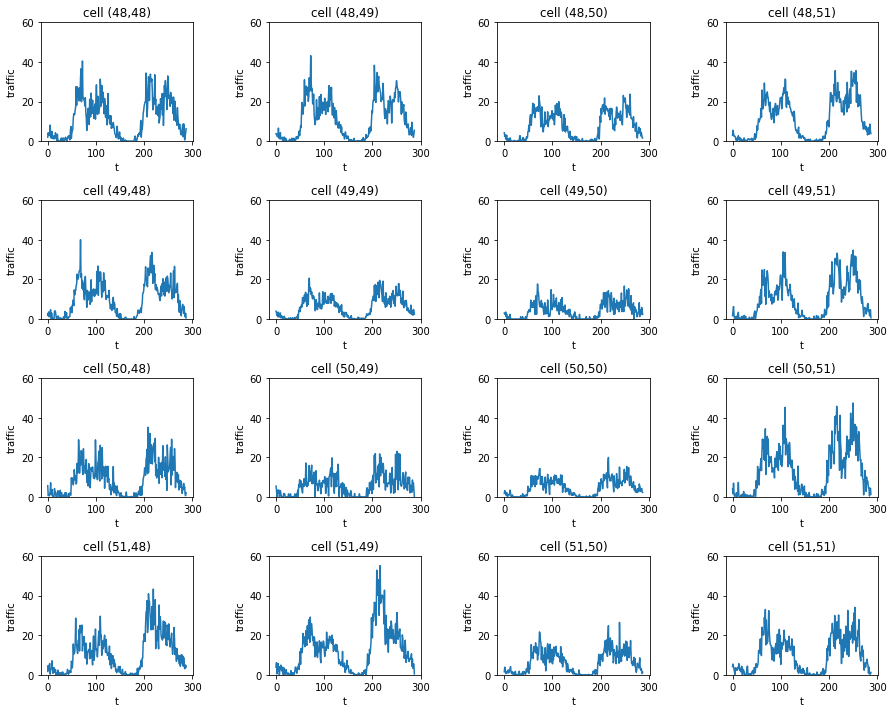

In [103]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(15,12))
t = np.arange(frames)
c = 48
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        y = raw[c+i,c+j,:]
        col.plot(t, y)
        col.set_ylim((0,60))
        col.set_title('cell ('+str(c+i)+','+str(c+j)+')')
        col.set_ylabel('traffic')
        col.set_xlabel('t')
plt.subplots_adjust(hspace = 0.5,wspace =0.5)
plt.show

<function matplotlib.pyplot.show>

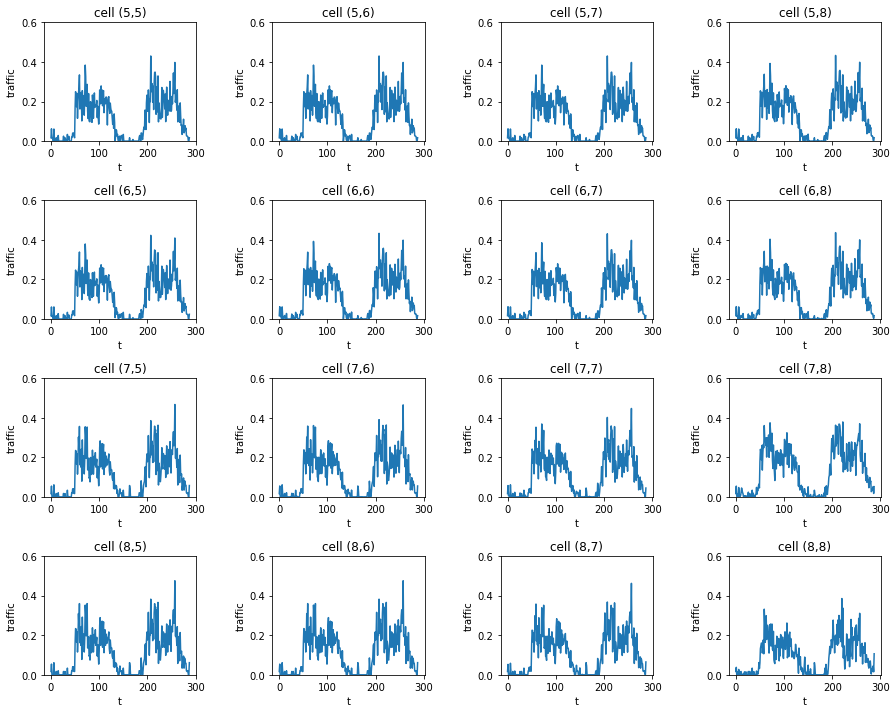

In [105]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(15,12))
t = np.arange(frames)
c = 5
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        y = raw[c+i,c+j,:]
        col.plot(t, y)
        col.set_ylim((0,0.6))
        col.set_title('cell ('+str(c+i)+','+str(c+j)+')')
        col.set_ylabel('traffic')
        col.set_xlabel('t')
plt.subplots_adjust(hspace = 0.5,wspace =0.5)
plt.show

## Tensorflow linear regression baseline

In [15]:
import tensorflow as tf

In [21]:
dataset = tf.data.Dataset.from_tensor_slices({'features': x,'predictions': y})

In [22]:
dataset.output_types

{'features': tf.float64, 'predictions': tf.float64}

In [23]:
dataset.output_shapes

{'features': TensorShape([Dimension(100), Dimension(100), Dimension(12)]),
 'predictions': TensorShape([Dimension(100), Dimension(100), Dimension(4)])}